In [1]:
import numpy as np
import torch as th
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def gbm_simulator_with_deltas(S0, mu, sigma, n_days=12, n_sequences=50000, annual_trading_days=252):
    sequences = []
    delta_sequences = []
    
    for i in range(n_sequences):
        # Time horizon and time step
        T = n_days / annual_trading_days
        dt = T / n_days
        
        # Time vector
        t = np.linspace(0, T, n_days)
        
        # Generate Wiener process increments
        W_increments = np.random.normal(0, np.sqrt(dt), n_days)
        W = np.cumsum(W_increments)  # Cumulative Wiener process
        
        # Geometric Brownian Motion (GBM) process
        S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
        
        # Calculate price deltas (differences between consecutive prices)
        Delta_GBM = np.diff(S)  # Price deltas
        
        sequences.append(S)
        delta_sequences.append(Delta_GBM)
    
    return np.array(sequences), np.array(delta_sequences)

def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, seq_length = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)

    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    # Split the data based on 60/20/20 ratio
    train_size = int(0.6 * n_sequences)
    val_size = int(0.2 * n_sequences)
    
    train_data = tokenized_sequences[:train_size]  # First 60% of sequences for training
    val_data = tokenized_sequences[train_size:train_size + val_size]  # Next 20% for validation
    test_data = tokenized_sequences[train_size + val_size:]  # Remaining 20% for testing

    print('Number of Tokens:', num_bins)
    print('Training Data Shape:', train_data.shape)
    print('Validation Data Shape:', val_data.shape)
    print('Test Data Shape:', test_data.shape)

    return train_data, val_data, test_data, num_bins

def plot_price_hist(price, deltas, bin_width):
    fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

    # Histogram: GBM Prices
    axs[0].hist(np.concatenate(price), bins=20, color='blue', density=True)
    axs[0].set_title('Histogram: GBM Prices')
    axs[0].set_xlabel('Price')
    axs[0].set_ylabel('Frequency')

    bins = np.arange(-5.1, 5.1 + bin_width, bin_width)

    # Histogram: GBM Price Deltas
    axs[1].hist(np.concatenate(deltas), 
                bins=bins, 
                edgecolor='orange', color='blue', density=True)
    axs[1].set_title('Histogram: GBM Price Deltas')
    axs[1].set_xlabel('Price Difference')
    axs[1].set_ylabel('Frequency')

    # Boxplot Price Deltas
    axs[2].boxplot(np.concatenate(deltas), vert=False)
    axs[2].set_title('Boxplot Price Deltas')
    axs[2].set_xlabel('Price Difference')
    plt.tight_layout()
    plt.show()

def plot_losses(pg_loss, value_loss, entropy_loss):

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(pg_loss, color='blue')
    axs[0].set_title('Policy Loss')
    axs[0].set_xlabel('Model Update')
    axs[0].set_ylabel('Value')

    axs[1].plot(value_loss, color='blue')
    axs[1].set_title('Value Loss')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylabel('Value')

    axs[2].plot(entropy_loss, color='blue')
    axs[2].set_title('Entropy Loss')
    axs[2].set_xlabel('Model Update')
    axs[2].set_ylabel('Value')
    
    #plt.tight_layout()
    plt.show()

def plot_rewards(ep_rew, ep_len, ep_time):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(ep_rew, color='blue')
    axs[0].set_title('Episode Reward')
    axs[0].set_ylabel('Reward')
    axs[0].set_xlabel('Episode')

    axs[1].plot(ep_len, color='blue')
    axs[1].set_title('Episode Length')
    axs[1].set_ylabel('Length')
    axs[1].set_xlabel('Episode')

    axs[2].plot(ep_time, color='blue')
    axs[2].set_title('Episode Time in Sec.')
    axs[2].set_ylabel('Time')
    axs[2].set_xlabel('Episode')

    plt.show()

def plot_discriminator():
    pass

Standard Deviation of Price Deltas: 1.263
BIN WIDTH:  0.3
Number of Tokens: 34
Training Data Shape: (30000, 11)
Validation Data Shape: (10000, 11)
Test Data Shape: (10000, 11)


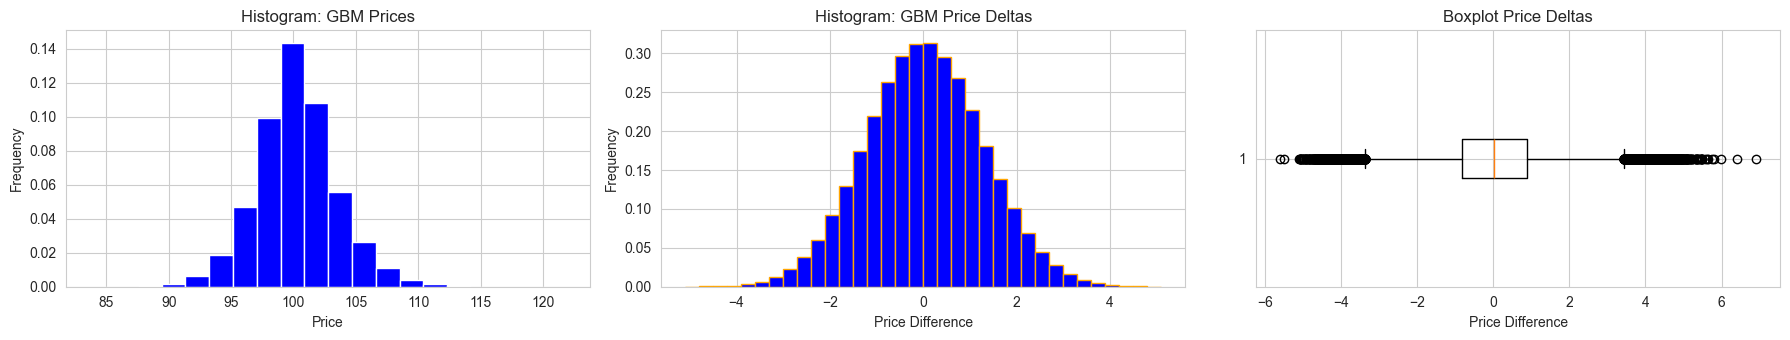

In [3]:
S0 = 100                # Initial stock price
mu = 0.1                # Annual drift
sigma = 0.2             # Volatility
n_days = 12             # Sequence length (52 days)
n_sequences = 50000     # Number of sequences to simulate

Price_GBM, Delta_GBM = gbm_simulator_with_deltas(S0, mu, sigma, n_days=n_days, n_sequences=n_sequences)

bin_width = 0.3
print('Standard Deviation of Price Deltas:', np.round(np.std(Delta_GBM.flatten()),3))
print('BIN WIDTH: ', bin_width)

train_data, val_data, test_data, token_size = tokenize_deltas(Delta_GBM, bin_start=-5.1, bin_stop=5.1, bin_width=bin_width)

plot_price_hist(Price_GBM, Delta_GBM, bin_width)


In [ ]:
class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug

    Those variables will be accessible in the callback
    (they are defined in the base class)
    The RL model
    self.model = None  # type: BaseRLModel
    An alias for self.model.get_env(), the environment used for training
    self.training_env = None  # type: Union[gym.Env, VecEnv, None]
    Number of time the callback was called
    self.n_calls = 0  # type: int
    self.num_timesteps = 0  # type: int
    local and global variables
    self.locals = None  # type: Dict[str, Any]
    self.globals = None  # type: Dict[str, Any]
    The logger object, used to report things in the terminal
    self.logger = None  # type: logger.Logger
    # Sometimes, for event callback, it is useful
    # to have access to the parent object
    self.parent = None  # type: Optional[BaseCallback]

    train/learning_rate
    train/entropy_loss
    train/policy_gradient_loss
    train/value_loss
    train/approx_kl
    train/clip_fraction
    train/loss
    train/explained_variance
    train/n_updates
    train/clip_range
    """
    
    def __init__(self, env, verbose=0, display_rollout=False):
        
        super(CustomCallback, self).__init__(verbose)
        self.env = env
        
        # Display Rollout
        self.display_rollout = display_rollout
        
        # Losses
        self.pg_losses = []
        self.value_losses = []
        self.entropy_losses = []

        # Rewards
        self.rewards = []

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:

        self.save_losses()

    def _on_step(self) -> bool:

        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        if self.display_rollout:
            self.display_rollout_buffer()
        
        self.save_reward()

        #self.env.get_wrapper_attr('calculate_kl_div')()
        #self.env.get_wrapper_attr('train_discrimintator')()

        self.reset_env_data()

    def _on_training_end(self) -> None:
        
        self.save_losses()

    def save_losses(self) -> None:
        self.pg_losses.append(self.logger.name_to_value.get('train/policy_gradient_loss', None))
        self.value_losses.append(self.logger.name_to_value.get('train/value_loss', None))
        self.entropy_losses.append(self.logger.name_to_value.get('train/entropy_loss', None))

    def display_rollout_buffer(self):
        print("\nRollout Buffer Contents:")
        
        # Create base DataFrame with flattened arrays
        df = pd.DataFrame({
            'observations': self.model.rollout_buffer.observations.reshape(-1),
            'actions': self.model.rollout_buffer.actions.reshape(-1),
            'rewards': self.model.rollout_buffer.rewards.reshape(-1),
            'returns': self.model.rollout_buffer.returns.reshape(-1),
            'episode_starts': self.model.rollout_buffer.episode_starts.reshape(-1),
            'values': self.model.rollout_buffer.values.reshape(-1),
            'log_probs': self.model.rollout_buffer.log_probs.reshape(-1),
            'advantages': self.model.rollout_buffer.advantages.reshape(-1)
        })
        
        # Find indices where episodes start
        episode_starts = np.where(df['episode_starts'])[0]
        
        # Create list to store all rows
        all_rows = []
        
        # Print header with line
        header = "  observations  actions  rewards  returns  episode_starts  values  log_probs  advantages"
        print("-" * (len(header) + 5))  # +5 for index space
        print("idx " + header)
        print("-" * (len(header) + 5))
        
        last_idx = -1
        for i in range(len(df)):
            if i in episode_starts:
                # Add double line if this is end of previous episode (not first episode)
                if last_idx != -1:
                    print("=" * (len(header) + 5))
                # Add "New Episode" row
                print(f"{i:3d} {'New Episode':^{len(header)}}")
                print("-" * (len(header) + 5))
                
            # Format row data with 2 decimal places
            row = df.iloc[i]
            print(f"{i:3d}  {row['observations']:8.0f}    {row['actions']:4.0f}    {row['rewards']:6.2f}  "
                f"{row['returns']:7.2f}  {row['episode_starts']:8.0f}      "
                f"{row['values']:6.2f}  {row['log_probs']:8.2f}  {row['advantages']:9.2f}")
            
            last_idx = i
        
        # Add final double line
        print("=" * (len(header) + 5))
        print('\n')

    def save_reward(self):
        
        # Get rewards and episode starts from rollout buffer
        rewards = self.model.rollout_buffer.rewards.reshape(-1)
        episode_starts = self.model.rollout_buffer.episode_starts.reshape(-1)
        
        # Find indices where episodes start
        ep_start_idx = np.where(episode_starts)[0]
        
        # Check if beginning has not a 1 (episode start)
        if not episode_starts[0]:                   # if episode_starts[0] == 0
            ep_start_idx = np.r_[0, ep_start_idx]   # faster than np.append
            
        # Fastest way to sum sequences
        sequence_rewards = np.add.reduceat(rewards, np.r_[0, ep_start_idx[1:]])

        self.rewards.append(sequence_rewards.mean())
    
    def reset_env_data(self):
        
        print('')
        print(self.env.real_train_seq)
        print(self.env.sim_train_seq)
        print('')

        self.env.real_train_seq = []
        self.env.sim_train_seq = []
        #self.env.set_wrapper_attr('real_train_seq', [])
        # self.training_env.set_attr('real_train_seq', [])
        # self.training_env.set_attr('sim_train_seq', [])
        
        print(self.env.real_train_seq)
        print(self.env.sim_train_seq)
        

    

In [ ]:
class CustomEnv(gym.Env):
    
    def __init__(self, train_data, val_data, token_size):
        
        super(CustomEnv, self).__init__()
        
        # Spaces
        self.action_space = spaces.Discrete(token_size)        # Action Space
        self.observation_space = spaces.Discrete(token_size)   # Observation Spacepass

        # Data
        self.train_data = train_data
        self.val_data = val_data
        
        # Reset
        self.seq_len = None
        self.curr_sim = []
        self.seq_position = 0
    
        # Just to compare KL in training
        self.real_train_seq = []
        self.sim_train_seq = []

        # Discriminator

    def step(self, action):

        assert self.action_space.contains(action), "Invalid Action"

        self.seq_position += 1

        self.curr_sim.append(action)

        done = self._is_done()

        ## REMOVE THIS
        if action == 25:
            reward = -0.1
        else:
            reward = -0.2
        ## REMOVE THIS

        if done:
            #reward = self._get_reward()
            # REWARD HERE
            self.sim_train_seq.append(self.curr_sim)
        #else:
        #    reward = 0

        next_obs = action

        return next_obs, reward, done, False, {}        # observation, reward, done, truncated, info

    def reset(self, *, seed = None, options = None):
        
        seq_idx = np.random.choice(len(self.train_data), size = 1).item()
        real_seq = self.train_data[seq_idx]

        self.real_train_seq.append(real_seq[1:])
        
        # Reset
        self.seq_len = len(real_seq)
        self.curr_sim = []
        self.seq_position = 0
        
        start_token = int(real_seq[0])

        return start_token, {}

    def _is_done(self):

        return self.seq_position == (self.seq_len - 1)

    def _get_reward(self):
        pass
    
    def calculate_kl_div(self):

        # real_counts = Counter(np.concatenate(self.real_data))
        # fake_counts = Counter(np.concatenate(self.sim_data))
        
        # total_real = len(np.concatenate(self.real_data))
        # total_fake = len(np.concatenate(self.sim_data))
        
        # real_probs = {token: count/total_real for token, count in real_counts.items()}
        # fake_probs = {token: count/total_fake for token, count in fake_counts.items()}
        pass

    def train_discrimintator(self):
        
        pass




In [48]:
env_test = CustomEnv(train_data=train_data, val_data=val_data, token_size=token_size)
env_test = Monitor(env_test, filename=None) 

model_test = PPO(
    policy='MlpPolicy',
    env=env_test,
    verbose=0,

    n_steps=250*10,
    batch_size=25*10,
    n_epochs=10,

    gamma=0.99,
    gae_lambda=0.95,

    clip_range=0.2,
    clip_range_vf=None,
    ent_coef=0.0,
    vf_coef=0.5,
    max_grad_norm=0.5,

    learning_rate=1e-4
)

callback_test = CustomCallback(env=env_test, verbose=0, display_rollout=False)

In [49]:
model_test.learn(10000, callback=callback_test)
env_test.close()

[array([21., 11., 11., 15., 10., 15., 22., 16., 12., 17.]), array([10., 22., 10., 11., 14., 15.,  9., 15., 13., 22.]), array([11., 18., 19., 21., 26., 10., 21., 10., 15., 23.]), array([17., 16., 18., 16., 12., 15., 16., 10., 12., 11.]), array([12., 13., 16.,  7., 20., 17., 21., 17., 10., 21.]), array([19., 11., 24., 23., 21., 23., 20., 23., 15., 15.]), array([26., 12., 17., 17., 14., 19., 15., 17., 24., 16.]), array([18., 18., 14.,  9., 17., 18., 16., 17., 16., 15.]), array([ 8., 17., 15., 20., 24., 22., 11., 16.,  9., 17.]), array([17., 17., 18., 16.,  9., 18., 14., 16., 15., 14.]), array([21., 23., 17., 13., 20., 20., 25., 18., 20., 13.]), array([17., 14., 18., 21., 11., 17., 15.,  9., 16., 22.]), array([16., 13., 20., 21., 15., 22., 10., 15., 15., 17.]), array([21., 16., 23., 14., 18.,  8., 13.,  9., 19., 15.]), array([10., 19., 15., 19., 20.,  8., 11., 18., 23., 17.]), array([12., 24., 15., 12., 18., 17., 16., 16., 16., 10.]), array([12., 11., 13., 13., 16., 10., 17.,  9., 22., 11.

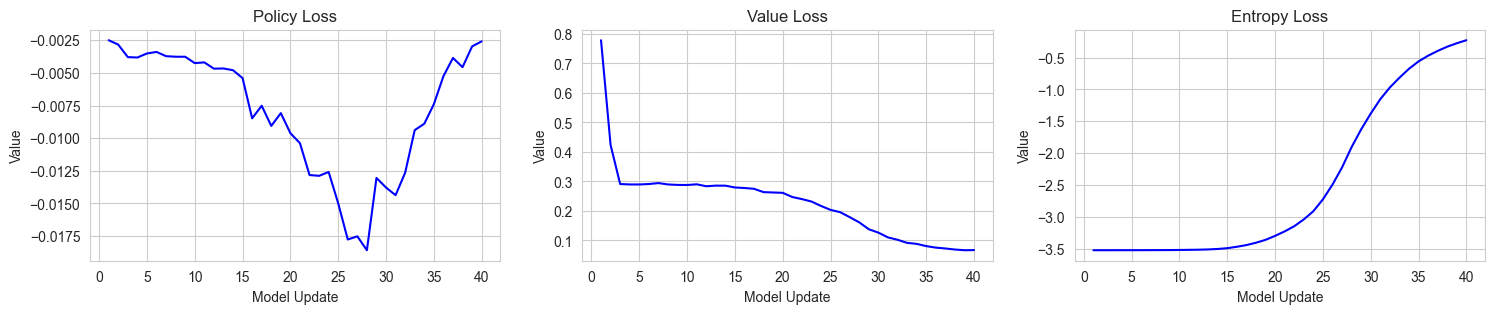

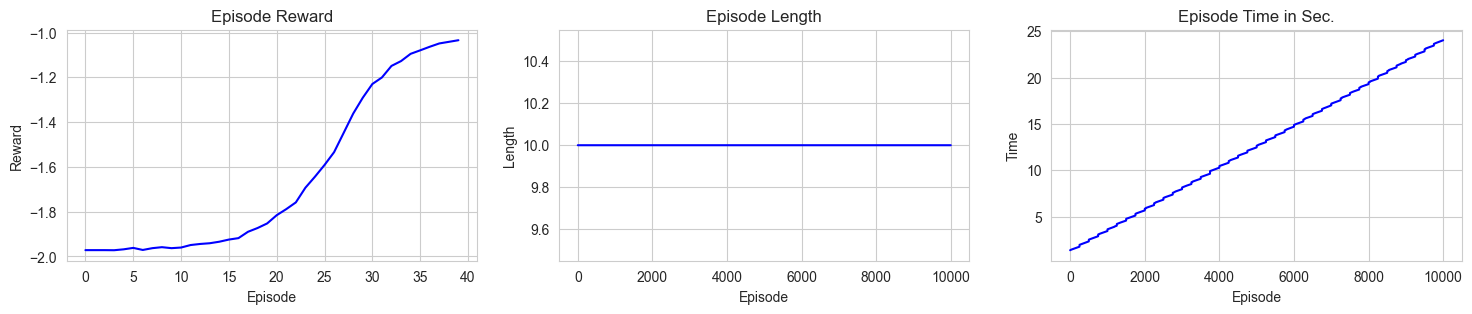

In [8]:
plot_losses(pg_loss=callback_test.pg_losses, 
            value_loss=callback_test.value_losses, 
            entropy_loss=callback_test.entropy_losses)

plot_rewards(ep_rew=callback_test.rewards,
             ep_len=env_test.get_episode_lengths(),
             ep_time=env_test.get_episode_times())

In [ ]:
env_taxi = gym.make('Pendulum-v1')
env_taxi = Monitor(env_taxi, filename=None) 

model_taxi = model = PPO(

    policy="MlpPolicy",
    env=env_taxi,
    verbose=0,
    
    n_steps=2048,
    batch_size = 64,
    n_epochs=10,
    
    learning_rate=3e-4,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    clip_range_vf=None,
    ent_coef = 0.0,
    vf_coef = 0.5,
    max_grad_norm=0.5
    )


In [108]:
callback_taxi = CustomCallback(env=env_taxi, verbose=0, display_rollout=False)
model_taxi.learn(500000, callback=callback_taxi)


env_taxi.close()

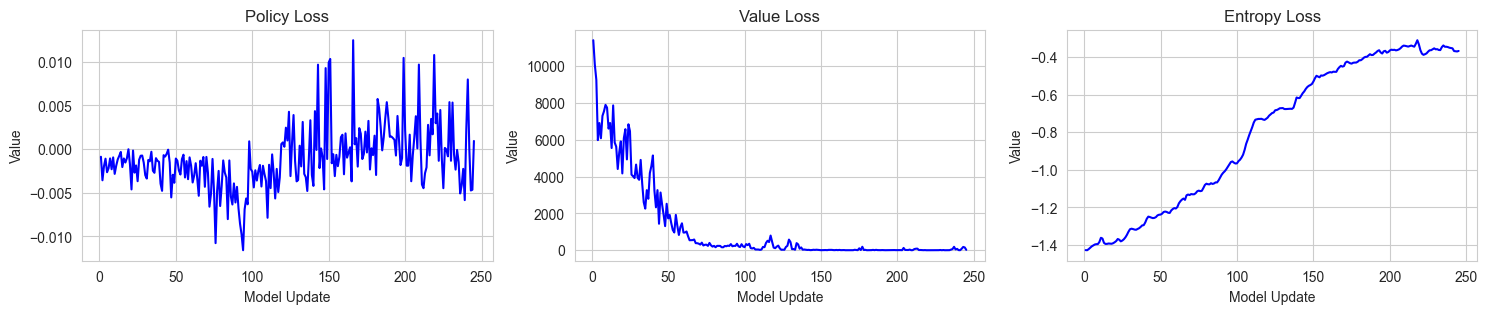

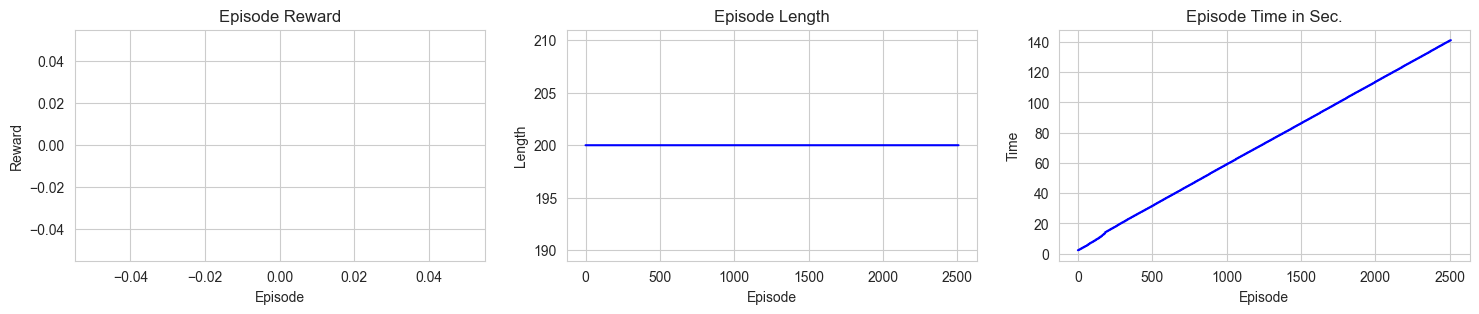

In [ ]:
plot_losses(pg_loss=callback_taxi.pg_losses, 
            value_loss=callback_taxi.value_losses, 
            entropy_loss=callback_taxi.entropy_losses)

plot_rewards(ep_rew=callback_taxi.rewards,
             ep_len=env_taxi.get_episode_lengths(),
             ep_time=env_taxi.get_episode_times())